In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot

%matplotlib inline

In [3]:
# no difference between .mat and .pkl
af = scipy.io.loadmat("dir_tune.mat")

In [4]:
direc = af["direction"]
spike_t = af["spikeTimes"]

In [5]:
print(direc.shape)
print(spike_t.shape)
spike_t

(1, 200)
(1, 200)


array([[ array([[ 0.205,  0.441,  0.555,  0.745,  1.141,  1.321,  1.58 ,  1.711,
         1.819]]),
        array([[ 0.225,  0.308,  0.343,  0.595,  0.626,  0.652,  0.686,  0.69 ,
         0.711,  1.192,  1.256,  1.323,  1.41 ,  1.445,  1.52 ,  1.588,
         1.662,  1.88 ,  1.905,  1.967]]),
        array([[ 0.062,  0.082,  0.092,  0.107,  0.151,  0.173,  0.213,  0.26 ,
         0.314,  0.328,  0.346,  0.348,  0.418,  0.445,  0.611,  0.614,
         0.64 ,  0.778,  0.924,  0.926,  0.988,  1.011,  1.08 ,  1.108,
         1.117,  1.193,  1.208,  1.251,  1.313,  1.314,  1.345,  1.363,
         1.367,  1.37 ,  1.383,  1.384,  1.425,  1.428,  1.436,  1.515,
         1.601,  1.615,  1.746,  1.851,  1.909,  1.967]]),
        array([[ 0.072,  0.386,  0.825,  0.854,  1.396,  1.918]]),
        array([[ 0.041,  0.069,  0.116,  0.142,  0.259,  0.306,  0.329,  0.406,
         0.428,  0.465,  0.484,  0.651,  0.662,  0.689,  0.72 ,  0.91 ,
         0.938,  0.941,  0.974,  0.976,  1.022,  1.15 ,  1.

In [6]:
zero_deg = spike_t[direc == 0]

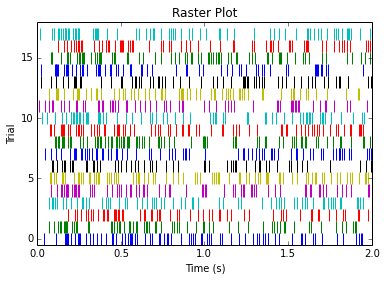

In [12]:
color_cycle = plt.rcParams['axes.color_cycle']

# plot the spike raster
for z_i, ze in enumerate(list(zero_deg)):
    color = [color_cycle[z_i % len(color_cycle)]]
    plt.eventplot(ze, colors=color, lineoffsets=[1*z_i])
plt.xlim(0, 2.0)
plt.ylim(-0.5, 1*zero_deg.shape[0])
plt.ylabel("Trial")
plt.xlabel("Time (s)")
plt.title("Raster Plot")

In [22]:
# hmmmmm... 5ms bins seems really small. Unless you want me to sum over all trials?
better_zd = []
for z_i in range(zero_deg.shape[0]):
    better_zd.append(zero_deg[z_i][0])
better_zd = np.array(better_zd)

In [146]:
# get the firing rate
bins = np.arange(0, 2.005, 0.005)
multi_trial_rate = np.zeros((bins.shape[0] - 1, better_zd.shape[0]))
for z_i in range(better_zd.shape[0]):
    multi_trial_rate[:, z_i] = np.histogram(better_zd[z_i], bins=bins)[0]

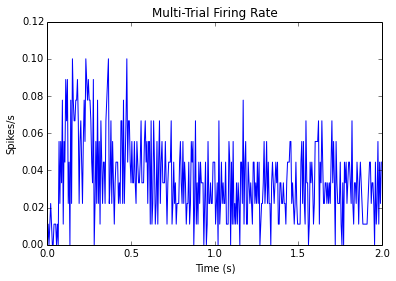

In [148]:
plt.plot(bins[:-1], np.mean(multi_trial_rate/5.0, axis=1))
plt.title("Multi-Trial Firing Rate")
plt.ylabel("Spikes/s")
plt.xlabel("Time (s)")
plt.savefig("multi-fr")

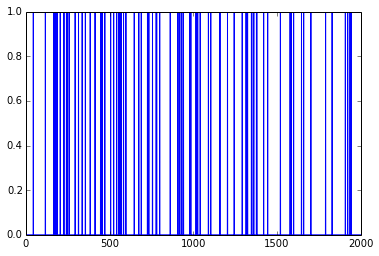

In [81]:
from scipy.ndimage.filters import gaussian_filter1d

trial = spike_t[0][8][0]
trial_t = np.arange(0, 2.001, 0.001)
sp_trial = np.zeros(trial_t.shape)
sp_trial[np.array(trial*1000, dtype=np.int64)] = 1
plt.plot(sp_trial)

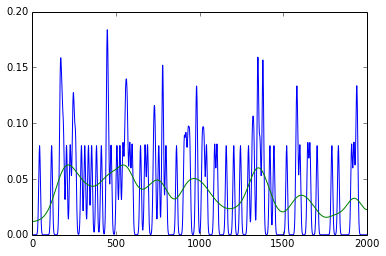

In [82]:
plt.plot(gaussian_filter1d(sp_trial, sigma=5))
plt.plot(gaussian_filter1d(sp_trial, sigma=50))

In [127]:
dirs = np.unique(direc)
d_spikes = [[] for _ in range(dirs.shape[0])]
n_spikes = [[] for _ in range(dirs.shape[0])]
spike_mean = [0.0 for _ in range(dirs.shape[0])]
spike_std = [0.0 for _ in range(dirs.shape[0])]

for d_i, d_val in enumerate(list(dirs)):
    # get the spikes for each trial
    tmp_spikes = spike_t[direc == d_val]
    
    # filter spikes to only take into account 50 to 250ms
    for t_s in range(tmp_spikes.shape[0]):
        tmp = tmp_spikes[t_s][0]
        tmp = tmp[np.where(tmp > 0.05)[0]]
        tmp = tmp[np.where(tmp < 0.25)[0]]
        d_spikes[d_i].append(tmp)
        n_spikes[d_i].append(tmp.shape[0])

        spike_mean[d_i] = np.mean(n_spikes[d_i])/(0.25-0.05)
        spike_std[d_i] = np.std(n_spikes[d_i])/(0.25-0.05)

d_spikes = np.array(d_spikes)
n_spikes = np.array(n_spikes)

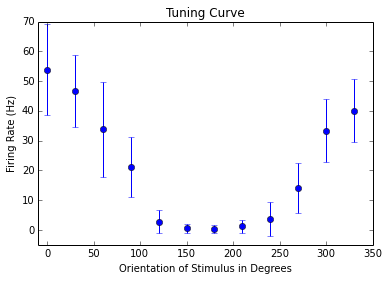

In [131]:
plt.errorbar(dirs, spike_mean, yerr=spike_std, fmt='o')
plt.xlim(-10, 350)
plt.ylim(-5, 70)
plt.title("Tuning Curve")
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Orientation of Stimulus in Degrees")